# Plot velocity change


In [1]:
import numpy as np
import geopandas as gpd
import rasterio as rio
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from collections import defaultdict


In [8]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'


Load in data

In [2]:
ifsar_hs_fp_utm = '/path/to/hillshade.tif' # utm7n hillshade (for background plot)
ifsar_hs_arr = rio.open(ifsar_hs_fp_utm).read(1)
xmin_hs, ymin_hs, xmax_hs, ymax_hs = rio.open(ifsar_hs_fp_utm).bounds


In [3]:
# get glacier centerline
def euclid_dist(xarray, yarray, zarray):
    dist = np.zeros_like(xarray)
    dist[1:] = np.cumsum(np.sqrt(np.diff(xarray) ** 2.0 + np.diff(yarray) ** 2.0 + np.diff(zarray) ** 2.0))
    return dist
    
cl = gpd.read_file('/path/to/oggm_kennicott_centerline.gpkg', crs='EPSG:4326').to_crs(32607) 

# pack points into goepandas series and convert to epsg 3338
s = gpd.GeoSeries(map(Point, list(list(cl.iloc[0].geometry.geoms)[0].coords)), crs='EPSG:3338')

# get projected x and y coords
cl_x = s.x.to_numpy()
cl_y = s.y.to_numpy()

# get distance along prof
cl_dist = euclid_dist(cl_x, cl_y, np.zeros_like(cl_x))

# repeat for Root
cl2 = gpd.read_file('/path/to/oggm_root_centerline.gpkg', crs='EPSG:4326').to_crs(32607) 
s2 = gpd.GeoSeries(map(Point, list(list(cl2.iloc[0].geometry.geoms)[0].coords)), crs='EPSG:3338')
cl2_x = s2.x.to_numpy()
cl2_y = s2.y.to_numpy()
cl2_dist = euclid_dist(cl2_x, cl2_y, np.zeros_like(cl2_x))
        

In [4]:
# flux gates
gate_labels = [['A', "A'"], ['B', "B'"], ['C', "C'"], ['D', "D'"], ['E', "E'"], ['F', "F'"], ['G', "G'"]]
all_stored_xvals_utm = [[391736, 395347], [393678, 397420],
                        [394471, 399479], [395204, 400100], 
                        [396289, 399286], [396164, 399147], [396171, 398920]]
all_stored_yvals_utm = [[6820118, 6823100], [6818357, 6821681],
                        [6816882, 6819358], [6815629, 6815366], 
                        [6825027, 6824957], [6823907, 6823686], [6822241, 6821930]]


In [6]:
# load raster data
raster_path = '/path/to/1960_2017_vel.tif' # 1960 velocity with holes
# raster_path = 'tmp_60_17f.tif' # 1960 filled velocity
raster_array = rio.open(raster_path).read(1)
raster_array[raster_array < -1e10] = np.nan
xmin, ymin, xmax, ymax = rio.open(raster_path).bounds

# load glacier outline
shp_fp = '/path/to/1957_outline.gpkg' # 1957 glacier outline
shp_data = gpd.read_file(shp_fp)

# our plot extent
new_xmin, new_ymin, new_xmax, new_ymax = xmin - 0, ymin - 2500, xmax, ymax - 1500


In [7]:
# sample raster at points
pt_a = (393000, 6821900)
pt_b = (396000, 6819900)
pt_c = (398000, 6818000)
pt_d = (397500, 6815350)
pt_e = (397500, 6822400)
pts = [pt_a, pt_b, pt_c, pt_d, pt_e]

# Billy Armstrong data
val_dict_armstrong = defaultdict(list)
for p in pts:
    fp = '/path/to/armstrong_etal_2021_data/'
    for r_fp in ['1960_vel.tif', '1991_vel.tif', '2005_vel.tif', '2015_vel.tif']:
        row, col = rio.open(fp+r_fp).index(p[0], p[1]) # get raster array index of coordinate
        val = rio.open(r_fp).read(1)[row][col] # sample raster at value
        val_dict_armstrong[p].append(val) # save value to dictionary with key

year_v_armstrong = [1960, 1991, 2005, 2015]
year_frac_armstrong = [(yr - min(year_v_armstrong)) / (max(year_v_armstrong) - min(year_v_armstrong)) for yr in year_v_armstrong]

# ITS LIVE DATA
val_dict_itslive = defaultdict(list)
for p in pts:
    fp = '/path/to/itslive_data/'
    for r_fp in ['1960_vel.tif', '1990_vel.tif', '2004_vel.tif', '2008_vel.tif', '2012_vel.tif', '2015_vel.tif', '2017_vel.tif']:
        row, col = rio.open(fp+r_fp).index(p[0], p[1]) # get raster array index of coordinate
        val = rio.open(r_fp).read(1)[row][col] # sample raster at value
        val_dict_itslive[p].append(val) # save value to dictionary with key

year_v_itslive = [1960, 1990, 2004, 2008, 2012, 2015, 2017]
year_frac_itslive = [(yr - min(year_v_itslive)) / (max(year_v_itslive) - min(year_v_itslive)) for yr in year_v_itslive]

# NOTE: both '1960_vel.tif' are from our data (PyCorr tracking of orthophotos)


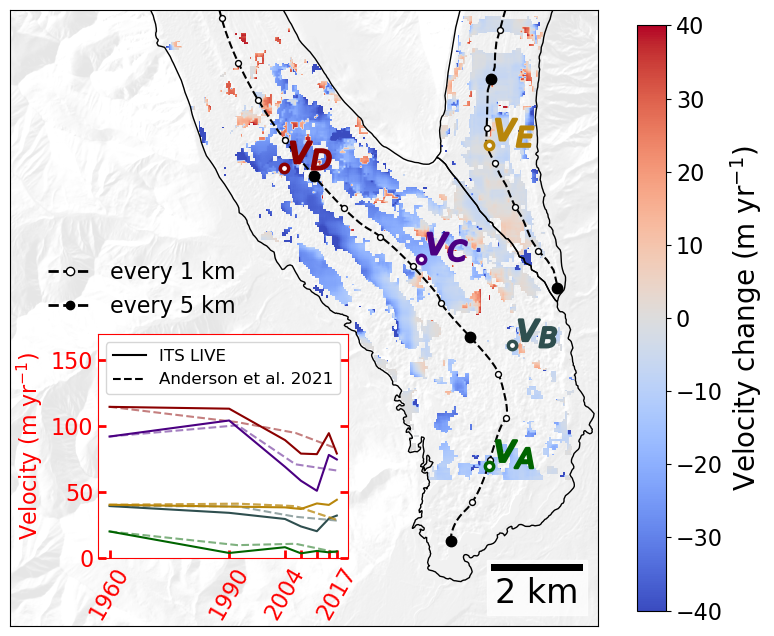

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

# plot raster and outline
ax.imshow(ifsar_hs_arr, cmap='Greys', extent=[xmin_hs, xmax_hs, ymin_hs, ymax_hs], vmin=100, vmax=255, alpha=0.1)

shp_data.plot(ax=ax, facecolor='none', edgecolor='k')
raster_array[raster_array > 40] = np.nan # filter out bad values to look better optically
c = ax.imshow(raster_array, cmap='coolwarm', extent=[xmin, xmax, ymin, ymax], vmin=-40, vmax=40, alpha=1)
ax.imshow(raster_array, cmap='coolwarm', extent=[xmin, xmax, ymin, ymax], vmin=-40, vmax=40, alpha=1)
fig.colorbar(c, ax=ax, label='Velocity change (m yr$^{-1}$)', shrink=0.95) # shrink=0.825

# add Kennicott centerline
ax.plot(cl_x, cl_y, c='k', ls='--', lw=1.5, alpha=1, zorder=1)
for km in range(0, 21):
    km_i = min(range(len(cl_dist)), key=lambda i: abs(cl_dist[i] - (cl_dist[-1] - km*1000)))
    if km % 5 == 0:
        ax.scatter(cl_x[km_i], cl_y[km_i], c='k', s=56, marker='o', alpha=1)
    else:
        ax.scatter(cl_x[km_i], cl_y[km_i], ec='k', fc='w', s=18, marker='o', alpha=1)

# add Root centerline
ax.plot(cl2_x, cl2_y, c='k', ls='--', lw=1.5, alpha=1, zorder=1)
for km in range(0, 7):
    km_i = min(range(len(cl2_dist)), key=lambda i: abs(cl2_dist[i] - (cl2_dist[-1] - km*1000)))
    if km % 5 == 0:
        ax.scatter(cl2_x[km_i], cl2_y[km_i], c='k', s=56, marker='o', alpha=1)
    else:
        ax.scatter(cl2_x[km_i], cl2_y[km_i], ec='k', fc='w', s=18, marker='o', alpha=1)

# add point(s)
c1, c2, c3, c4, c5 = 'darkred', 'indigo', 'darkslategrey', 'darkgreen', 'darkgoldenrod'
vel_abc = [chr(68), chr(67), chr(66), chr(65), chr(69)]
colors = [c1, c2, c3, c4, c5]

# create an inset axis
inset_ax = fig.add_axes([0.245, 0.195, 0.25, 0.28])  # [left, bottom, width, height]
inset_axl = inset_ax.twinx()
inset_axl.plot(0, 0, c='k', ls='-', label='ITS LIVE')
inset_axl.plot(0, 0, c='k', ls='--', label='Anderson et al. 2021')
inset_axl.legend(fontsize=12, loc='upper center')

for i, pt in enumerate(pts):
    ax.scatter(*pt, color='w', ec=colors[i], lw=2.5, marker='o', s=36, label='Point '+chr(65+i), zorder=20) # with label
    t = ax.annotate(f'$v_{vel_abc[i]}$', xy=(pt[0] + 100, pt[1] + 100), c=colors[i], size='xx-large', zorder=20)
    t.set_path_effects([path_effects.withStroke(linewidth=2, foreground=colors[i]), path_effects.Normal()])
    inset_ax.plot(year_frac_itslive, val_dict_itslive[pt], c=colors[i], label=chr(65+i))
    inset_ax.plot(year_frac_armstrong, val_dict_armstrong[pt], c=colors[i], ls='--', label=chr(65+i), alpha=0.5)

inset_ax.plot(year_frac_armstrong, val_dict_armstrong[pt_e], c=c5, ls='--', label='E', alpha=0.5)
inset_ax.tick_params(axis='x', rotation=60)
plt.xticks(year_frac_itslive, [1960, 1990, 2004, '', '', '', 2017])

inset_ax.set_ylim(0,170)
inset_ax.tick_params(axis='both', direction='in', labelsize=16, bottom=True, top=False, left=True, right=True, length=6, width=2)
inset_ax.set_ylabel('Velocity (m yr$^{-1}$)', c='r', size=16)
inset_ax.tick_params(axis='both', labelsize=16, labelcolor='r', color='r')
inset_axl.tick_params(top=False, bottom=False, left=False, right=False, 
                      labelbottom=False, labelleft=False, labeltop=False, labelright=False)
for spine in inset_axl.spines.values():
    spine.set_edgecolor(None)
for spine in inset_ax.spines.values():
    spine.set_edgecolor('red')

# add scalebar
scalebar = ScaleBar(1,  # 1 data unit per pixel
                    location='lower right',  # location of the scalebar
                    length_fraction=0.2,  # relative length of the scalebar
                    box_color='white',  # box background color
                    box_alpha=0.75,  # transparency of the background box
                    color='black', border_pad=0.5, font_properties={'size':24})

ax.add_artist(scalebar)


legend_handles = [Line2D([0], [0], ls='--', marker='o', mfc='w', mew=1, mec='k', lw=2, color='k', label='every 1 km'),
                  Line2D([0], [0], ls='--', marker='o', mfc='k', mew=1, mec='k', lw=2, color='k', label='every 5 km')]
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(0.03, 0.625), fontsize=16, frameon=False)

# plot limits
ax.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False, left=False, right=False)
ax.set_xlim(new_xmin-2500+500, new_xmax+500-1200)
ax.set_ylim(new_ymin-700, new_ymax+1650)
plt.show()
